# EC analysis with cellpose

#### This analysis aims to normalise detected signal areas to the number of cells in the slice. To do this, machine learning model 'nuclei' from cellpose is used. It was tested and works pretty well, but:

- the newest version of cellpose (cellpose 4) is no longer compatible the nuclei model and only 'cpasm' model downloads (which should handle everything). The problem is, that this model is too computationally heavy for computers without GPU (like mine). At one point I tested it on one image and it took over 20min (after that I interrupted the kernel as there is no point having script that takes that long). That is the reason why the cellpose this script uses is cellpose2.2.3.

- currently takes about ~1min per image

- has problems with very nuclei-dense areas, but is nonetheless very accurate

- the python version is also Python 3.10.18 (older from the base env.), because it's compatible with the version of cellpose this script uses

#### Tasks:
- *DONE: script creates nuclei masks and saves them into a new folder, downstream analysis pulls on these saved masks (saves time in case of individual image corrections/re-working the script)*
- *DONE: organoid mask is created based on the nuclei mask*
- *DONE: figure out how to script where to assign the nuclei if they lay on any of the image borders (e.g. if >50% is in epicardium, the nuclei is in epicardium)*
- *DONE: rewrite the script so that it records the area per number of nuclei*
- *DONE(? - area is being recorded in the cell staging script): quality control - size of the nuclei is recorded and the info about average value/error bars is put into the script output*
- *DONE: test of cell cycle staging - since I'm already recording the nuclei, I might as well test if I can identify cell cycle stage distribution in the organoid (secondary script output)*
- *DONE: add option that if image name contains 5x, 10x, 20x, 40x (etc.) the pixel_size changes accordingly (with 10x likely being the default option)*
- *DONE: make a new way to record masks*
- *DONE: figure out the distances problem** - are the distances mathematical artifact of the script (proliferation would cause the distances to naturally decrease over time)*
- *DONE: make a cutoff distance of ~20um - count the number of ECs that have a macrophage within that distance*
- *DONE: to make the distances more accurate, figure out how to do the surface-to-surface thing... - either Euclidian distance transform, or surface dilation (since I don't need every single object, but only objects within a certain radius of the endothelial cell)*
- *DONE (resp.gotten rid of): subepicardium border is a) renamed and b) dependent on the level of gaussian blurring(?)*
- *DONE: border zone is erased since I don't use the blurring for 594/cTnT gating*
- *DONE* add distances and EC analysis into a single script for better accuracy (no sense having 2 sets of parameters applied to a single image)
- *DONE* make sure that when counting against the total number of nuclei its the total within the identified organoid area??? Since there are nuclei here and there that are left out... but the number is minimal <10 for d1... so it likely isn't necessary. Those are probably debri or really separated nuclei of macrophages that are too far from the organoid to be included


Still TO-DO:

- take care of the distances mask (currently makes thick outline of all ECs together, instead of individually)
- make the fill_in_small_holes() scricter for 405 mask (there are many cavities that are counted in epicardium and shouldn't be)
- also the thrash in the border region that is counted as EC is possibly messing up the distances

- Handle the 'division by zero' in area/nuclei calculations (what happens if there is no epi/myo? - put in try/except block?)


In [3]:
### LIBRARY
import os
import glob
from skimage import io
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from skimage.io import imsave
from skimage.filters import try_all_threshold
from skimage.filters import threshold_minimum, threshold_isodata, threshold_triangle, threshold_mean
from skimage.filters import threshold_otsu, threshold_li, threshold_yen
from skimage.morphology import binary_dilation
from scipy.ndimage import binary_erosion
from scipy.ndimage import distance_transform_edt
from skimage.segmentation import watershed
from skimage.filters import gaussian
from skimage.morphology import label
from skimage.measure import regionprops
from skimage.segmentation import clear_border
from skimage.segmentation import relabel_sequential
from skimage.morphology import remove_small_objects
from skimage.morphology import remove_small_holes
from skimage.morphology import dilation, disk
from scipy.ndimage import binary_dilation
from scipy.spatial.distance import cdist
from statistics import mean, stdev
import re
from natsort import natsorted
from skimage.color import label2rgb
from skimage import exposure
from skimage.morphology import closing
from skimage.exposure import equalize_adapthist

## addition for distances:
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage import measure
from skimage.segmentation import find_boundaries
import math

In [18]:
### PARAMETERS
filename = ''

pixel_size = 0.65

# filename extract
last_folder = os.path.basename(filename)
# output folder:
output_folder = ''

# to save masks:
folder1 = f'{filename}/masks_with_nuclei_count'
folder2 = f'{filename}/masks_nuclei'
os.makedirs(folder1, exist_ok=True)
os.makedirs(folder2, exist_ok=True)

print(last_folder)

# to correctly extract the channels:
nuclei_mask_suffix = '_ch00_mask.tif'
ch405_suffix = '_ch00.tif'
ch488_suffix = '_ch01.tif'
ch594_suffix = '_ch02.tif'
ch647_suffix = '_ch03.tif'

# to correctly calculate the area:
pixel_size_5x = 1.3
pixel_size_10x = 0.65
pixel_size_20x = 0.325
pixel_size_40x = 0.1625

# to correctly calculate mac sizes for the distances and random distribution:
estimated_mac_radius = 6.5 #in um
measured_dist_around_EC = 29.9 #in um (for the distances calculation - how far from the EC does mac count as relevant)
estimated_mac_area = math.pi*(estimated_mac_radius**2)

ImmEpis_EXP6_d3_GFP_cTnT_CD31


In [19]:
### LOADING IMAGES

## DAPI in 405 channel:
list_of_dapi_files = natsorted(glob.glob(f"{filename}/*ch00*.tif"))
images_dapi = {}
images_dapi_list = []
for file in list_of_dapi_files:
    img = io.imread(file)
    images_dapi[os.path.basename(file)] = img
    images_dapi_list.append(img)

## 488 channel:
list_of_488_files = natsorted(glob.glob(f"{filename}/*ch01*.tif"))
images_488 = {}
for file in list_of_488_files:
    img = io.imread(file)
    images_488[os.path.basename(file)] = img

## 594 channel:
list_of_594_files = natsorted(glob.glob(f"{filename}/*ch02*.tif"))
images_594 = {}
for file in list_of_594_files:
    img = io.imread(file)
    images_594[os.path.basename(file)] = img

## 647 channel:
list_of_647_files = natsorted(glob.glob(f"{filename}/*ch03*.tif"))
images_647 = {}
for file in list_of_647_files:
    img = io.imread(file)
    images_647[os.path.basename(file)] = img

print(f"to check: \n number of 405 images: \t {len(images_dapi)}, \n number of 488 images: \t {len(images_488)},"
      f"\n number of 594 images: \t {len(images_594)}, \n number of 647 images: \t {len(images_647)}")


to check: 
 number of 405 images: 	 15, 
 number of 488 images: 	 15,
 number of 594 images: 	 15, 
 number of 647 images: 	 15


In [20]:
## Grabbing the cellpose masks from the folder

list_of_nuclei_mask_files = natsorted(glob.glob(f"{folder2}/*.tif"))
nuclei_masks = {}

for file in list_of_nuclei_mask_files:
    img = io.imread(file)
    nuclei_masks[os.path.basename(file)] = img

print(f'Number of nuclei masks: {len(nuclei_masks)}')

Number of nuclei masks: 15


In [21]:
### PARAMETERS testing

# tested_image = 'd1_1' #'Image 1'

def dapi_analysis(mask):
    thresholding = mask > threshold_triangle(mask)
    dilated = binary_dilation(thresholding, iterations=100) #dilates the individual nuclei by 100 pixels
                                                            #this covers up the holes/spaces in between
                                                            #also bridges whatever cavities etc. are present 
    thresholding_2 = remove_small_holes(dilated, area_threshold=1000) #removes the remaining holes
    eroded = binary_erosion(thresholding_2, iterations=80) #erodes the expanded mask back to original size
                                                           #basically 'tightens' the mask to better fit the 
                                                           #organoid
    thresholding_3 = remove_small_objects(eroded, min_size=8000) #removes stray nuclei outside of the organoid
    blurred = gaussian(thresholding_3, sigma=10) #blurrs the jagged edges
    smoothed = blurred > 0.2 #blurring makes the image non-binary, this makes it binary again by selecting
                             #the intensities over certain threshold (in this case everything over 20%)
    return(smoothed)

## 488
def analysis_488(image):
    thresholding_1 = image > threshold_triangle(image) #originaly otsu
    thresholding_2 = remove_small_objects(thresholding_1, min_size=100) #100
    return(thresholding_2)

## 594
def analysis_594(image):
    blurring = gaussian(image,sigma=10) #blurred, because the channel has a lot of debri/unclear signal
                                        #this pools the signal together/removes some of the background
    thresholding = blurring > threshold_li(blurring)
    thresholding_1 = remove_small_objects(thresholding, min_size=5000)
    dilated = binary_dilation(thresholding_1, iterations=45)
    thresholding_2 = remove_small_holes(dilated, area_threshold=200000)
    eroded = binary_erosion(thresholding_2, iterations=45)
    thresholding_3 = remove_small_objects(eroded, min_size=15000)
    return(thresholding_3)

## 647
def analysis_647(image):
    normalisation = equalize_adapthist(image, clip_limit=0.009)
    cutoff = np.percentile(normalisation, 99.2)
    thresholding_1 = normalisation > cutoff #originaly threshold_triangle() / 470
    thresholding_2 = remove_small_objects(thresholding_1, min_size=150)
    return(thresholding_2)



# ### Implementation to actual data:

# image_dapi_test = nuclei_masks[f'{tested_image}{nuclei_mask_suffix}'] #_ch00.tif_mask.tif
# image_thresholded = dapi_analysis(image_dapi_test)

# image_488_test = images_488[f'{tested_image}{ch488_suffix}']
# thresholded_488_test = analysis_488(image_488_test)

# image_594_test = images_594[f'{tested_image}{ch594_suffix}']
# thresholded_594_test = analysis_594(image_594_test)

# image_647_test = images_647[f'{tested_image}{ch647_suffix}']
# thresholded_647_test = analysis_647(image_647_test)


# # ## testing of thresholding:
# # # tries all automatic thresholding options for the image 
# # fig, ax = try_all_threshold(mask_blur_dapi, figsize=(6, 12), verbose=False)
# # plt.show()

# fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16,7))
# axs[0,0].imshow(image_dapi_test, cmap='viridis', vmin=0, vmax=15)
# axs[0,1].imshow(image_thresholded)
# axs[1,0].imshow(thresholded_488_test)
# axs[1,1].imshow(thresholded_594_test)
# axs[1,2].imshow(thresholded_647_test)

# fig, ax = plt.subplots(figsize=(8, 8))
# # Show background image
# ax.imshow(image_thresholded, cmap='gray')
# # Nuclei
# ax.imshow(np.ma.masked_where(image_dapi_test == 0, image_dapi_test), cmap='Spectral', vmin=0, vmax=1, alpha=0.8)
# # macrophages
# ax.imshow(np.ma.masked_where(thresholded_488_test == 0, thresholded_488_test), cmap='Greens', vmin=0, vmax=1, alpha=0.9)
# # myocardium
# ax.imshow(np.ma.masked_where(thresholded_594_test == 0, thresholded_594_test), cmap='magma', alpha=0.4)
# # CD31
# ax.imshow(np.ma.masked_where(thresholded_647_test == 0, thresholded_647_test), cmap="Wistia_r", alpha=1) #vmin=low, vmax=high


# # OLD script to show cTnT overlay in red
# # from matplotlib.colors import LinearSegmentedColormap
# # red_black = LinearSegmentedColormap.from_list("red_black", ["black", "red"])
# # ax.imshow(np.ma.masked_where(image_594_test == 0, image_594_test), cmap=red_black, vmin=150, vmax=250, alpha=0.5)


In [22]:
## Distances functions

def watershed_488(mask): # this exists solely for me to get approx number of macrophages in a slice
    distance_transform_488 = ndi.distance_transform_edt(mask)
    # Find peaks (likely centers of individual cells)
    local_maxi_test = peak_local_max(distance_transform_488, labels=mask, footprint=np.ones((3, 3)), min_distance=30) #originaly 30
    local_maxi_test_2 = np.zeros_like(distance_transform_488, dtype=bool)
    local_maxi_test_2[tuple(local_maxi_test.T)] = True
    # Label the peaks
    markers = measure.label(local_maxi_test_2)
    # watershed
    watershed_labels_test = watershed(-distance_transform_488, markers, mask=mask)
    return(watershed_labels_test)

## fake 488 mask

def fake_mac_analysis(organoid_area, mac_number, mac_size):
    # this determines where the pixels are positive in the dapi mask:
    organoid_coords = np.column_stack(np.where(organoid_area))
    # this selects random coordinates inside the positive area of the dapi mask that is equal to the number 
    # of macs detected (approximated since the macs are basically a single mass and not individual cells)
    select_indeces = np.random.choice(len(organoid_coords), size=mac_number, replace=False)
    selected_coords = organoid_coords[select_indeces]
    # new 'fake' mac mask:
    seed_mask = np.zeros_like(organoid_area, dtype=bool)
    seed_mask[selected_coords[:,0], selected_coords[:,1]] = 1
    dilated = binary_dilation(seed_mask, disk(mac_size))
    fake_mac_mask = np.logical_and(dilated, organoid_area)

    return(fake_mac_mask)

# image_488_test = images_488[f'{tested_image}{ch488_suffix}']
# thresholded_488_test = analysis_488(image_488_test)
# dist_test_488 = watershed_488(thresholded_488_test)
# objects_488_test = regionprops(dist_test_488)
# mean_areas_test = [obj.area for obj in objects_488_test]
# print(mean(mean_areas_test)*(0.65**2)) # average mac area from the image mask (271um^2 for d1_1)

mac radius: 10 and number of iter: 46
Total number of nuclei is lager than sum of epi+myo nuclei in : Image 1 
 and 7 nuclei are outside of measurement area
Image 1_ch00.tif
mac radius: 10 and number of iter: 46
Image 2_ch00.tif
mac radius: 10 and number of iter: 46
Total number of nuclei is lager than sum of epi+myo nuclei in : Image 3 
 and 2 nuclei are outside of measurement area
Image 3_ch00.tif
mac radius: 10 and number of iter: 46
Total number of nuclei is lager than sum of epi+myo nuclei in : Image 4 
 and 1 nuclei are outside of measurement area
Image 4_ch00.tif
mac radius: 10 and number of iter: 46
Total number of nuclei is lager than sum of epi+myo nuclei in : Image 5 
 and 4 nuclei are outside of measurement area
Image 5_ch00.tif
mac radius: 10 and number of iter: 46
Total number of nuclei is lager than sum of epi+myo nuclei in : Image 6 
 and 1 nuclei are outside of measurement area
Image 6_ch00.tif
mac radius: 10 and number of iter: 46
Total number of nuclei is lager than 

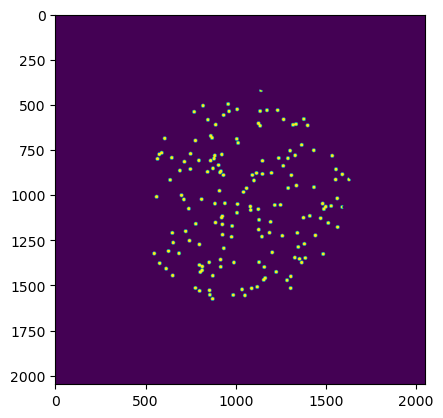

In [ ]:
### Analysis
Image_data_CD31_files = {}
Individual_data_CD31_files = {}


for name,img in images_dapi.items():

    #image name extracted:
    name_without_last_part = '_'.join(name.split('_')[:-1]) # splits the ch__ from the name, so that
                                                              # the script can get the relevant images 
                                                              # from other channels

    # pixel size extracted from 'name' (if available, otherwise default pixel size is used)
    if '5x' in name:
        pixel_size = pixel_size_5x
    elif '10x' in name:
        pixel_size = pixel_size_10x
    elif '20x' in name:
        pixel_size = pixel_size_20x
    elif '40x' in name:
        pixel_size = pixel_size_40x

    mac_rad = round(estimated_mac_radius/pixel_size) # approximation of macrophage size
    
    # normal mac diameter in EXP6 was measured to be ~15um (~23 pixels) and after measuring areas of 
    # macrophages (N=7), the radius was calculated to be 6.13um (~9.4 pixels)
    # therefore, the new mac_rad is going to be 6.5um - 10 pixels, for the ease of calculations

    number_of_iter = round(29.9/pixel_size) # the recorded distance around EC (46 iter for 10x objective)
    # sanity check:
    print(f'mac radius: {mac_rad} and number of iter: {number_of_iter}')


    ### Creation of masks for the individual channels in the image:   
                                                 
    ## 405 (DAPI)
    mask_405 = nuclei_masks[f'{name_without_last_part}{nuclei_mask_suffix}'] #_ch00.tif_mask.tif
    thresholded_405 = dapi_analysis(mask_405) # organoid mask by blurring nuclei together
    nuclei_objects = regionprops(mask_405, img)
    ## 488 (macs)
    img_488 = images_488[f'{name_without_last_part}{ch488_suffix}']
    thresholded_488 = analysis_488(img_488) & thresholded_405 #only signal overlapping with organoid mask is captured
    ## 594 (cTnT)
    img_594 = images_594[f'{name_without_last_part}{ch594_suffix}']
    myocardium = analysis_594(img_594) & thresholded_405
    ## 647 (CD31/CDH5)
    img_647 = images_647[f'{name_without_last_part}{ch647_suffix}']
    thresholded_647 = analysis_647(img_647) & thresholded_405


    ### Calculations:
    
    #DAPI signal/organoid size
    organoid_size = np.sum(thresholded_405) #sum of all pixels, area in pixels^2
    organoid_size_in_um = organoid_size*(pixel_size**2) #area in um^2
    number_of_nuclei = mask_405.max() #number of nuclei detected by cellpose

    # GFP signal/mac area
    overal_488_signal = np.sum(thresholded_488) #sum of all pixels, area in pixels^2
    mac_signal_in_um = overal_488_signal*(pixel_size**2)

    # 594 signal/cTnT area
    myocardium_area = np.sum(myocardium)
    myocardium_area_in_um = myocardium_area*(pixel_size**2)
    cTnT_per = myocardium_area/organoid_size

    epicardium = thresholded_405 & (~myocardium)
    epicardium_size = np.sum(epicardium)
    epicardium_size_in_um = epicardium_size*(pixel_size**2)
    epicardium_area_per = epicardium_size/organoid_size

    #number of nuclei in myocardium:
    nuclei_count_myo = 0
    nuclei_count_epi = 0

    nuclei_sizes_in_um = []

    for obj in nuclei_objects:
        coordinates = obj.coords
        nucleus_area = obj.area
        nuclei_sizes_in_um.append(nucleus_area*(pixel_size**2))

        # nuclei in myocardium
        overlap_myo = np.sum(myocardium[coordinates[:,0], coordinates[:,1]])
        overlap_myo_per = overlap_myo/nucleus_area
        # nuclei in epicardium
        overlap_epi = np.sum(epicardium[coordinates[:,0], coordinates[:,1]])
        overlap_epi_per = overlap_epi/nucleus_area

        if overlap_myo_per > 0.5:
            nuclei_count_myo += 1

        if overlap_epi_per > 0.5:
            nuclei_count_epi += 1


    if nuclei_count_epi ==0:
        print(f"There is no epicardium in: {name_without_last_part}")

    if (nuclei_count_epi+nuclei_count_myo) != number_of_nuclei:
        print(f"Total number of nuclei is lager than sum of epi+myo nuclei in : {name_without_last_part} \n and "
              f"{number_of_nuclei-(nuclei_count_epi+nuclei_count_myo)} nuclei are outside of measurement area")


    # 647 signal/CD31 area
    overal_647_signal = np.sum(thresholded_647)
    CD31_signal_in_um = overal_647_signal*(pixel_size**2)
    CD31_area_per = overal_647_signal/organoid_size
    CD31_area_per_nuclei = CD31_signal_in_um/number_of_nuclei

    macs_area_per = overal_488_signal/organoid_size
    macs_area_per_nuclei = mac_signal_in_um/number_of_nuclei
    

    ## are CD31+ in epicardium or myocardium?

    # area of signal per number of nuclei in epi/myo
    CD31_in_epi = thresholded_647 & epicardium #this is an array
    CD31_in_epi_um = np.sum(CD31_in_epi)*(pixel_size**2) #this is pixel area converted to um^2
    CD31_in_epi_per_nuclei = CD31_in_epi_um/nuclei_count_epi #area um^2 per the number of nuclei
    CD31_per_in_epicardium = np.sum(CD31_in_epi)/overal_647_signal #percentage of CD31 in epicardium

    CD31_in_myo = thresholded_647 & myocardium
    CD31_in_myo_um = np.sum(CD31_in_myo)*(pixel_size**2)
    CD31_in_myo_per_nuclei = CD31_in_myo_um/nuclei_count_myo
    CD31_per_in_myocardium = np.sum(CD31_in_myo)/overal_647_signal

    ## are GFP+ in epicardium or myocardium?
    GFP_in_epi = thresholded_488 & epicardium
    GFP_in_epi_um = np.sum(GFP_in_epi)*(pixel_size**2)
    GFP_in_epi_per_nuclei = GFP_in_epi_um/nuclei_count_epi
    GFP_per_in_epicardium = np.sum(GFP_in_epi)/overal_488_signal

    GFP_in_myo = thresholded_488 & myocardium
    GFP_in_myo_um = np.sum(GFP_in_myo)*(pixel_size**2)
    GFP_in_myo_per_nuclei = GFP_in_myo_um/nuclei_count_myo
    GFP_per_in_myocardium = np.sum(GFP_in_myo)/overal_488_signal

    #miscelaneous:
    per_of_myo_nuclei = nuclei_count_myo/number_of_nuclei
    per_of_epi_nuclei = nuclei_count_epi/number_of_nuclei






    ### Distances:
    # this part searches the radius of 30 um around CD31+ cell for the nearest macrophages + finds what total
    # macrophage area is around the EC (approximation to the number of macrophages within the radius)
    # it also creates a randomised mask of fake 'macrophages' and does the analysis with them as a randomised
    # control to compare

    labelled_647 = label(thresholded_647)
    objects_647 = regionprops(labelled_647,img_647)
    num_CD31_cells = labelled_647.max()

    watersheded_488 = watershed_488(thresholded_488)
    objects_488 = regionprops(watersheded_488,img)
    num_macrophages = watersheded_488.max()

    # fake mac mask created:
    fake_mac_mask = fake_mac_analysis(thresholded_405, num_macrophages, mac_rad)
    labels_fake_mac = label(fake_mac_mask)
    objects_fake_488 = regionprops(labels_fake_mac)

    ## Start of distance analysis

    #this is for the real data:
    original_areas = []
    nearest_distances = []
    mac_area_around_EC = []
    mac_nb_around_EC = []
    # this is for the randomised control:
    random_nearest_distances = []
    random_mac_area_around_EC = []
    random_mac_nb_around_EC = []

    for obj in objects_647:
        obj_mask = np.zeros_like(thresholded_488, dtype=bool)
        obj_mask[tuple(obj.coords.T)] = True

        original_area = obj.area*(pixel_size**2)
        original_areas.append(original_area)

        ## this is for the real data:
        #nearest distance:
        if np.any(obj_mask & (thresholded_488)):
            nearest_distances.append(0)
        else:
            for i in range(1, number_of_iter + 1):
                dilated_obj = binary_dilation(obj_mask, iterations=i)
                if np.any(dilated_obj & thresholded_488):
                    nearest_distances.append(i)
                    break
            else:
                nearest_distances.append(number_of_iter+1)

        #mac overlap:
        dilated_obj_2 = binary_dilation(obj_mask.copy(), iterations=number_of_iter)
        mac_area_in_radius = np.sum(thresholded_488 & dilated_obj_2)
        mac_area_around_EC.append(mac_area_in_radius*(pixel_size**2))

        overlapping_macs = 0
        for object in objects_488:
            coords = object.coords
            if np.any(dilated_obj_2[coords[:,0], coords[:,1]]):
                overlapping_macs += 1

        mac_nb_around_EC.append(overlapping_macs)

        ##this is for randomised control:
        if np.any(obj_mask & (fake_mac_mask)):
            random_nearest_distances.append(0)
        else:
            for i in range(1, number_of_iter + 1):
                dilated_obj = binary_dilation(obj_mask, iterations=i)
                if np.any(dilated_obj & fake_mac_mask):
                    random_nearest_distances.append(i)
                    break
            else:
                random_nearest_distances.append(number_of_iter+1)

        #mac overlap:
        random_mac_area_in_radius = np.sum(fake_mac_mask & dilated_obj_2)
        random_mac_area_around_EC.append(random_mac_area_in_radius*(pixel_size**2))

        overlapping_fake_macs = 0
        for object in objects_fake_488:
            coords = object.coords
            if np.any(dilated_obj_2[coords[:,0], coords[:,1]]):
                overlapping_fake_macs += 1

        random_mac_nb_around_EC.append(overlapping_fake_macs)
    

    # percentage of ECs without a macrophage in 30um radius around them
    per_of_unmac_ECs = nearest_distances.count(number_of_iter+1)/num_CD31_cells
    per_of_unmac_ECs_ctrl = random_nearest_distances.count(number_of_iter+1)/num_CD31_cells
    # average area of macs that can be found within 30um radius around EC in um^2
    average_mac_area = mean(mac_area_around_EC)
    average_mac_area_ctrl = mean(random_mac_area_around_EC)
    # average CD31 area in um
    average_CD31_area = mean(original_areas)
    # what is says, nearest distance from EC to macrophage in um
    nearest_dist_um = [d * pixel_size for d in nearest_distances]
    random_nearest_dist_um = [d * pixel_size for d in random_nearest_distances]
    # average distance to the nearest macrophage in um
    average_min_dist = mean(nearest_dist_um)
    average_min_dist_ctrl = mean(random_nearest_dist_um)

    # Distances mask:
    expanded_ECs = binary_dilation(thresholded_647, iterations=number_of_iter)
    mask_outline = find_boundaries(expanded_ECs)
    thick_outline = binary_dilation(mask_outline, disk(2))




    # image mask:
    fig, ax = plt.subplots(figsize=(8, 8))

    # Show background image
    ax.imshow(thresholded_405, cmap='gray')
    # Overlay cTnT in magenta
    ax.imshow(np.ma.masked_where(myocardium == 0, myocardium), cmap='magma', alpha=0.4)
    # Overlay macrophages in green
    ax.imshow(np.ma.masked_where(thresholded_488 == 0, thresholded_488), cmap='Greens', vmin=0, vmax=1, alpha=0.9)
    # Overlay CD31 in red
    ax.imshow(np.ma.masked_where(thresholded_647 == 0, thresholded_647), cmap='autumn', alpha=0.8)
    # Nuclei
    ax.imshow(np.ma.masked_where(mask_405 == 0, mask_405), cmap='Blues', vmin=0, vmax=1, alpha=0.8)

    ax.set_title(f"Channel masks for image: {name_without_last_part}")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"{folder1}/{name_without_last_part}.png", dpi=300, bbox_inches='tight')
    plt.close(fig)

    # image mask distances:
    fig2, ax2 = plt.subplots(figsize=(8, 8))
    ax2.imshow(thresholded_405, cmap='gray')
    ax2.imshow(np.ma.masked_where(myocardium == 0, myocardium), cmap='magma', alpha=0.4)
    ax2.imshow(np.ma.masked_where(thresholded_488 == 0, thresholded_488), cmap='Greens', vmin=0, vmax=1, alpha=0.9)
    ax2.imshow(np.ma.masked_where(thresholded_647 == 0, thresholded_647), cmap='autumn', alpha=0.8)
    ax2.imshow(np.ma.masked_where(thick_outline == 0, thick_outline), cmap='grey', alpha=0.9)
    ax2.set_title(f"Channel masks for image: {name_without_last_part}")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"{folder1}/{name_without_last_part}_distances.png", dpi=300, bbox_inches='tight')
    plt.close(fig2)

    # image mask fake macs:
    plt.imshow(fake_mac_mask)
    plt.savefig(f"{folder1}/{name_without_last_part}_fake_macs.png", dpi=300, bbox_inches='tight')
    plt.close()

    # image data
    Image_data_CD31_files[name_without_last_part] = {
        'organoid area [px^2]': organoid_size,
        'organoid area [um^2]': organoid_size_in_um,
        'number of nuclei': number_of_nuclei,
        'average nuclei size [um^2]': mean(nuclei_sizes_in_um),
        'nuclei sizes stdev': stdev(nuclei_sizes_in_um),
        'myocardium area [px^2]': myocardium_area,
        'myocardium area [um^2]': myocardium_area_in_um,
        'myocardium area [%]': cTnT_per,
        'myocardium nuclei': nuclei_count_myo,
        'myocardium nuclei [%]': per_of_myo_nuclei,
        'epicardium area [px^2]': epicardium_size,
        'epicardium area [um^2]': epicardium_size_in_um,
        'epicardium area [%]': epicardium_area_per,
        'epicardium nuceli': nuclei_count_epi,
        'epicardium nuclei [%]': per_of_epi_nuclei,
        'CD31 area [um^2]': CD31_signal_in_um,
        'GFP area [um^2]': mac_signal_in_um,
        'macs in epicardium [%]': GFP_per_in_epicardium,
        'macs in myocardium [%]': GFP_per_in_myocardium,
        'CD31 in epicardium [%]': CD31_per_in_epicardium,
        'CD31 in myocardium [%]': CD31_per_in_myocardium,
        'CD31 per nucleus count': CD31_area_per_nuclei,
        'macs per nucleus count': macs_area_per_nuclei,
        'CD31 in epi per nuclei': CD31_in_epi_per_nuclei,
        'CD31 in myo per nuclei': CD31_in_myo_per_nuclei,
        'macs in epi per nuclei': GFP_in_epi_per_nuclei,
        'macs in myo per nuclei': GFP_in_myo_per_nuclei,

        # distances:
        'CD31_number': num_CD31_cells,
        'CD31 average area': average_CD31_area,
        'Mac number': num_macrophages,
        'EC w/o mac [%]': per_of_unmac_ECs,
        'EC w/o mac ctrl [%]': per_of_unmac_ECs_ctrl,
        'Average min distance [um]': average_min_dist,
        'Average min distance ctrl [um]': average_min_dist_ctrl,
        'Average mac area in radius [um^2]': average_mac_area,
        'Average mac area in radius ctrl [um^2]': average_mac_area_ctrl,
        'Average mac number in radius': mean(mac_nb_around_EC),
        'Average mac number in radius ctrl': mean(random_mac_nb_around_EC)

    }

    Individual_data_CD31_files[name_without_last_part] = {
        'CD31_areas': original_areas,
        'Minimal distances': nearest_dist_um,
        'Minimal distances ctrl': random_nearest_dist_um,
        'Mac area in radius': mac_area_around_EC,
        'Mac area in radius ctrl': random_mac_area_around_EC,
        'Mac nb in radius': mac_nb_around_EC,
        'Mac nb in radius ctrl': random_mac_nb_around_EC
    }

    print(name)

In [24]:
### DATAFRAME
df_stain1 = pd.DataFrame.from_dict(Image_data_CD31_files, orient='index')

output_path = f'{output_folder}/{last_folder}.xlsx'
df_stain1.to_excel(output_path)

# distances:
output_path_2 = f'{output_folder}/{last_folder}_individual_distnaces.xlsx'
dfs = []
for name, data in Individual_data_CD31_files.items():
    max_len = max(len(v) for v in data.values())
    df_img = pd.DataFrame({k: pd.Series(v) for k, v in data.items()})
    df_img["Image"] = name
    
    dfs.append(df_img)

df_all = pd.concat(dfs, ignore_index=True)
cols = ["Image"] + [c for c in df_all.columns if c != "Image"]
df_all = df_all[cols]
df_all.to_excel(output_path_2, index=False)

## NOTE to self: epicardium size - overal CD31 area correlation?